Epoch   1  Train MSE: 5.9239
Epoch   2  Train MSE: 5.6180
Epoch   3  Train MSE: 5.2898
Epoch   4  Train MSE: 5.0195
Epoch   5  Train MSE: 4.6862
Epoch   6  Train MSE: 4.3292
Epoch   7  Train MSE: 4.0032
Epoch   8  Train MSE: 3.6296
Epoch   9  Train MSE: 3.3048
Epoch  10  Train MSE: 2.9750
Epoch  11  Train MSE: 2.7275
Epoch  12  Train MSE: 2.3853
Epoch  13  Train MSE: 2.1840
Epoch  14  Train MSE: 1.9231
Epoch  15  Train MSE: 1.7609
Epoch  16  Train MSE: 1.5830
Epoch  17  Train MSE: 1.4095
Epoch  18  Train MSE: 1.2969
Epoch  19  Train MSE: 1.2074
Epoch  20  Train MSE: 1.1119
Epoch  21  Train MSE: 1.0518
Epoch  22  Train MSE: 0.9919
Epoch  23  Train MSE: 0.9332
Epoch  24  Train MSE: 0.8808
Epoch  25  Train MSE: 0.8415
Epoch  26  Train MSE: 0.8068
Epoch  27  Train MSE: 0.7842
Epoch  28  Train MSE: 0.7539
Epoch  29  Train MSE: 0.7212
Epoch  30  Train MSE: 0.6951
Epoch  31  Train MSE: 0.6663
Epoch  32  Train MSE: 0.6427
Epoch  33  Train MSE: 0.6221
Epoch  34  Train MSE: 0.5994
Epoch  35  Tra

/tmp/ipykernel_16245/4190513429.py:162: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x10_i = float(x10_i_n * ds.x10_std + ds.x10_mean)
/tmp/ipykernel_16245/4190513429.py:163: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_i   = float(y_i_n   * ds.y_std   + ds.y_mean)


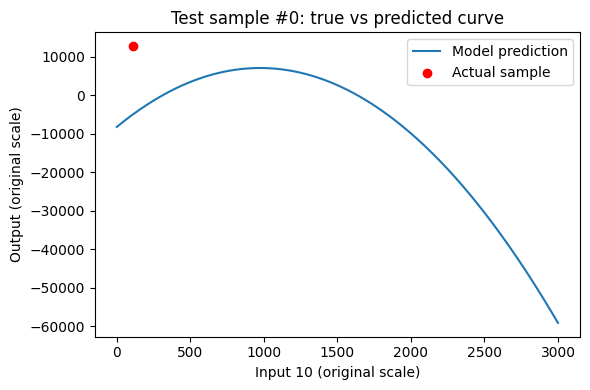

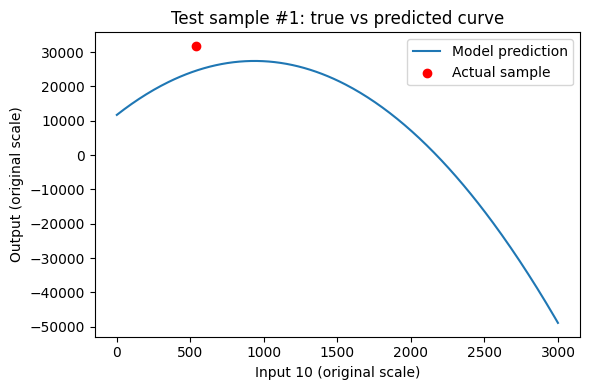

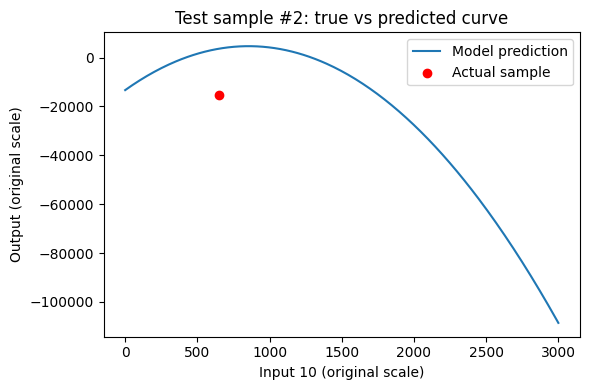

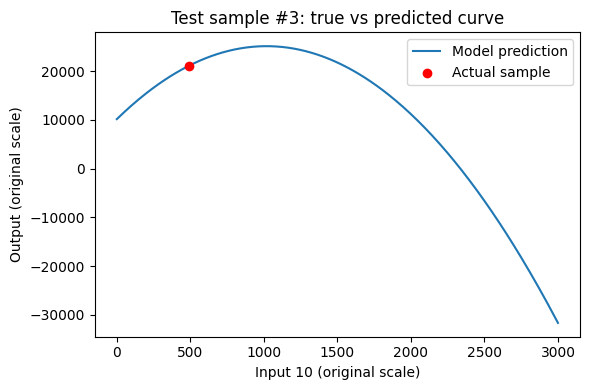

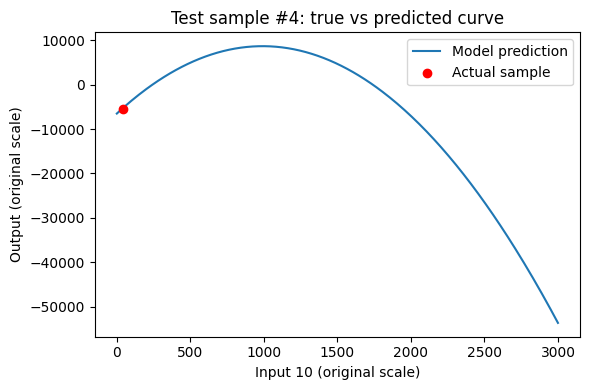

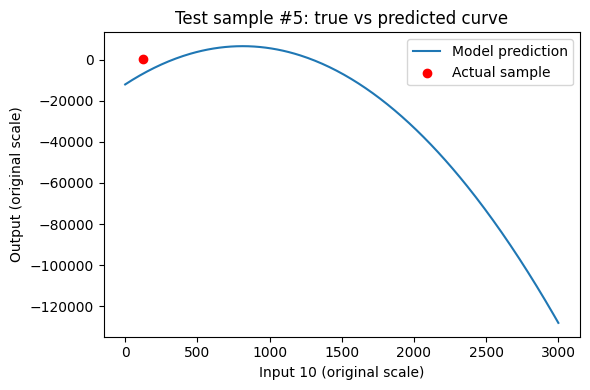

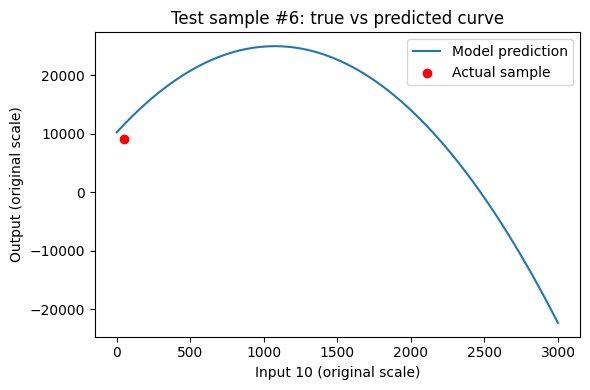

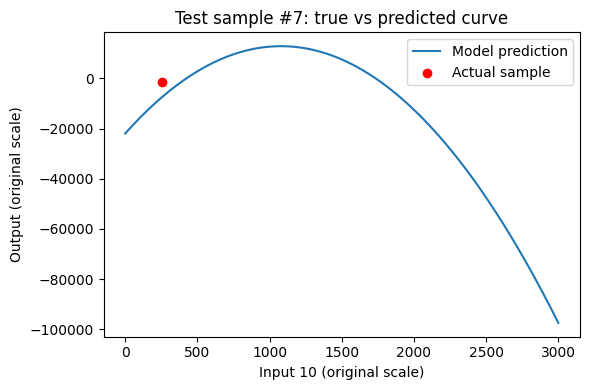

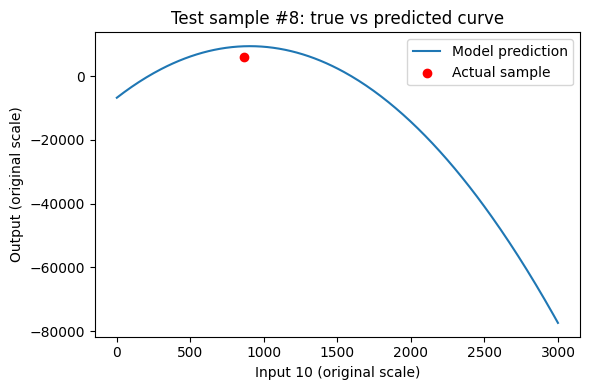

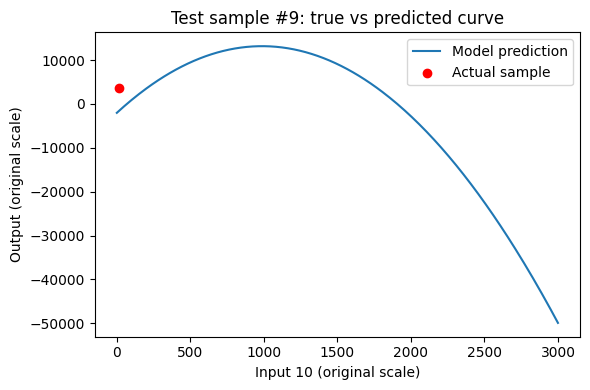

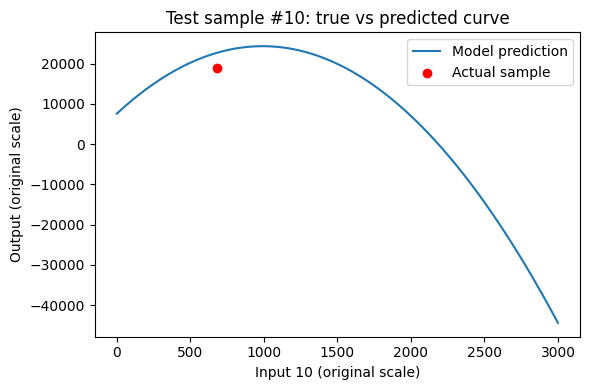

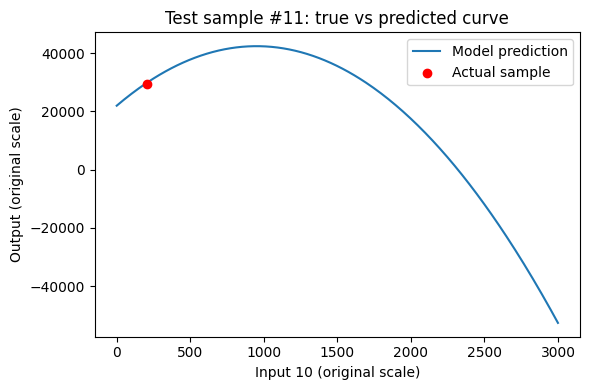

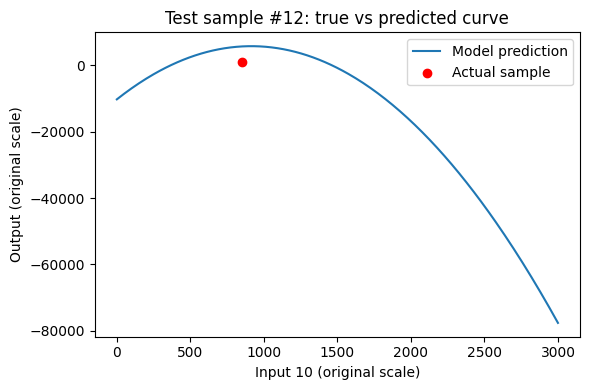

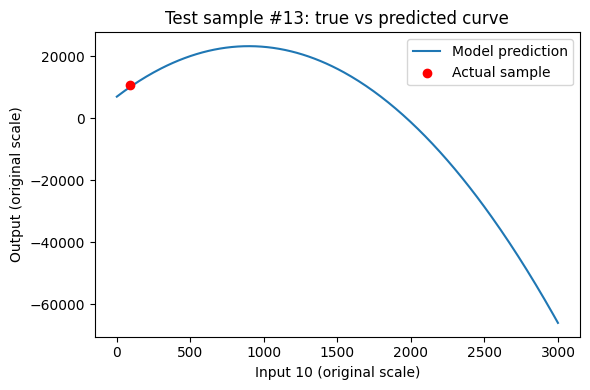

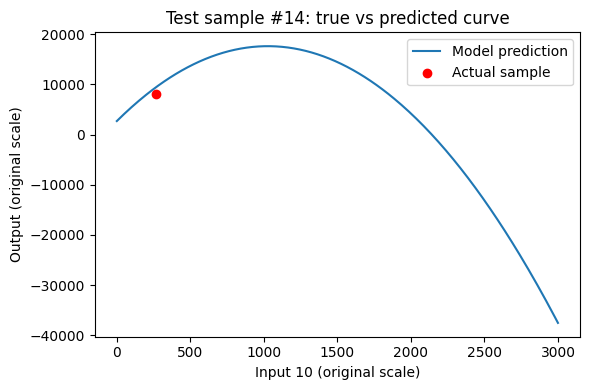

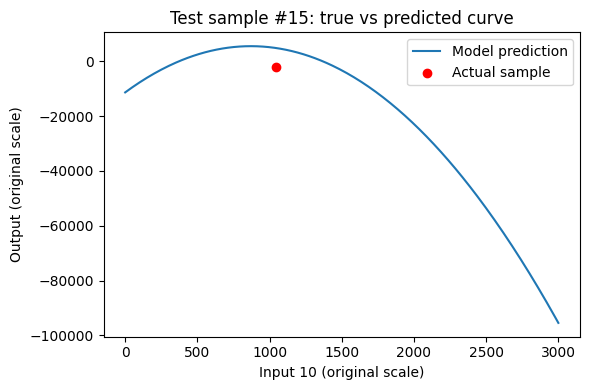

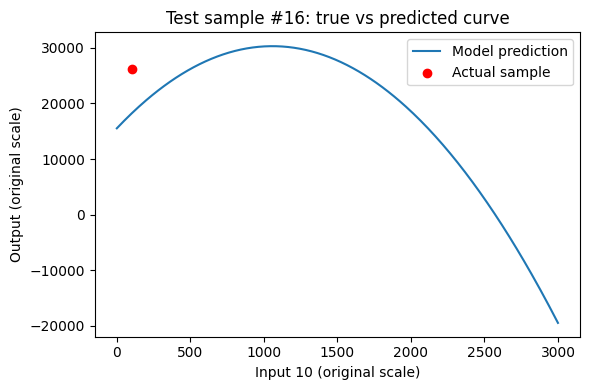

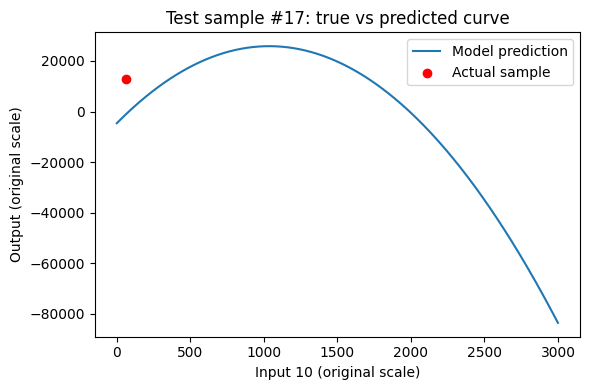

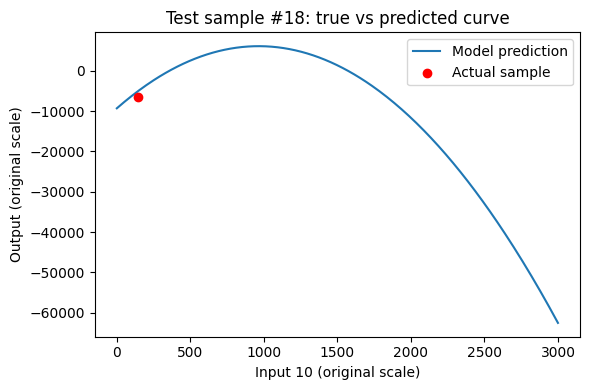

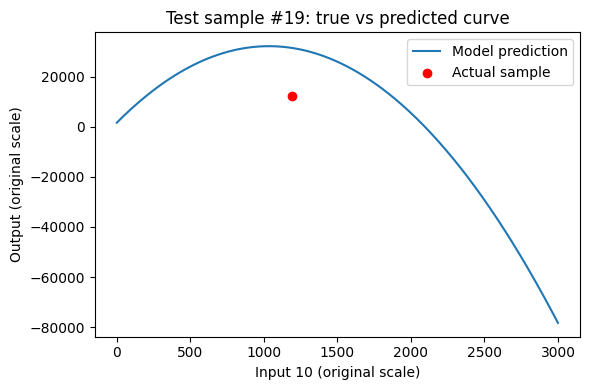

In [16]:
# Updated script with `a = -self.softplus(self.A(Z))`

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────────────────────────
# 1) FIXED SETTINGS
# ────────────────────────────────────────────────────────────────────────────────
categories_map = {
    'Input 1': [1, 2],
    'Input 2': list(range(1, 6)),
    'Input 3': list(range(1, 6)),
    'Input 4': list(range(1, 22)),
    'Input 5': list(range(1, 6)),
    'Input 6': [1, 2, 3],
    'Input 7': [1, 2, 3, 4],
    'Input 8': list(range(1, 11)),
}

all_inputs = [f'Input {i}' for i in range(1, 19)]
z_inputs = [c for c in all_inputs if c not in ('Input 10', 'Input 12')]
numeric_z_inputs = [f'Input {i}' for i in range(9, 19) if i not in (10, 12)]

HIDDEN_DIMS = [4, 4]
ACTIVATION  = 'relu'
EPOCHS      = 100
LR          = 1e-3
BATCH_SIZE  = 16
TEST_SIZE   = 0.2
RANDOM_SEED = 42
CSV_PATH    = '/home/kamiar/chevron/Acid-neural-net/First Data-V2/data/train_val.csv'

# ────────────────────────────────────────────────────────────────────────────────
# 2) DATASET CLASS
# ────────────────────────────────────────────────────────────────────────────────
class AcidDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        for c in ('F2', 'F3'):
            if c in df.columns:
                df = df.drop(columns=c)
        y = df['Output'].to_numpy(dtype=np.float32).reshape(-1,1)
        self.y_mean, self.y_std = y.mean(), (y.std() if y.std()!=0 else 1.0)
        self.y = (y - self.y_mean) / self.y_std
        Xz = df[z_inputs].copy()
        X10 = df['Input 10'].to_numpy(dtype=np.float32).reshape(-1,1)
        self.x10_mean = X10.mean()
        self.x10_std  = X10.std() if X10.std()!=0 else 1.0
        self.X10 = (X10 - self.x10_mean) / self.x10_std

        for col, cats in categories_map.items():
            if col not in Xz.columns:
                continue
            if len(cats) == 2:
                Xz[col] = Xz[col].map({cats[0]: +1.0, cats[1]: -1.0})
            else:
                Xz[col] = pd.Categorical(Xz[col], categories=cats)
                d = pd.get_dummies(Xz[col], prefix=col)
                for c in cats:
                    nm = f"{col}_{c}"
                    if nm not in d.columns:
                        d[nm] = 0
                Xz = pd.concat([Xz.drop(columns=[col]), d], axis=1)

        numeric_present = [c for c in numeric_z_inputs if c in Xz.columns]
        m, s = Xz[numeric_present].mean(), Xz[numeric_present].std().replace(0,1.0)
        Xz[numeric_present] = (Xz[numeric_present] - m) / s

        self.Z = Xz.to_numpy(dtype=np.float32)
        assert len(self.Z) == len(self.y) == len(self.X10)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.Z[idx]),
            torch.from_numpy(self.X10[idx]),
            torch.from_numpy(self.y[idx])
        )

# ────────────────────────────────────────────────────────────────────────────────
# 3) MODEL DEFINITION
# ────────────────────────────────────────────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dims, activation):
        super().__init__()
        layers = []
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            if activation == 'relu':    layers.append(nn.ReLU())
            elif activation == 'tanh':   layers.append(nn.Tanh())
            elif activation == 'sigmoid':layers.append(nn.Sigmoid())
            elif activation == 'softplus':layers.append(nn.Softplus())
            else: raise ValueError(f"Unknown activation '{activation}'")
            in_dim = h
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class PolyNet(nn.Module):
    def __init__(self, z_dim, hidden_dims, activation):
        super().__init__()
        self.A = MLP(z_dim, hidden_dims, activation)
        self.B = MLP(z_dim, hidden_dims, activation)
        self.C = MLP(z_dim, hidden_dims, activation)
        self.softplus = nn.Softplus()

    def forward(self, Z, x10):
        a = -self.softplus(self.A(Z))  # NOTE the minus here
        b = self.B(Z)
        c = self.C(Z)
        return a * (x10**2) + b * x10 + c

# ────────────────────────────────────────────────────────────────────────────────
# 4) TRAIN & EVALUATE
# ────────────────────────────────────────────────────────────────────────────────
def train_and_evaluate(csv_path):
    ds = AcidDataset(csv_path)
    N = len(ds)
    idx = np.arange(N)
    tr_idx, te_idx = train_test_split(idx, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    tr_ds = torch.utils.data.Subset(ds, tr_idx)
    te_ds = torch.utils.data.Subset(ds, te_idx)
    tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True)
    te_loader = DataLoader(te_ds, batch_size=BATCH_SIZE)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = PolyNet(z_dim=ds.Z.shape[1], hidden_dims=HIDDEN_DIMS, activation=ACTIVATION).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    for epoch in range(1, EPOCHS+1):
        model.train()
        total = 0.0
        for Z, x10, y in tr_loader:
            Z, x10, y = Z.to(device), x10.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(Z, x10), y)
            loss.backward()
            opt.step()
            total += loss.item() * Z.size(0)
        print(f"Epoch {epoch:3d}  Train MSE: {total/len(tr_ds):.4f}")

    return model, ds, te_idx, device

# ────────────────────────────────────────────────────────────────────────────────
# 5) PLOTTING HELPER
# ────────────────────────────────────────────────────────────────────────────────
def plot_sample_prediction(model, ds, test_idx, i=0, device='cpu', num_points=300):
    idx = test_idx[i]
    Z_i      = ds.Z[idx:idx+1]
    x10_i_n  = ds.X10[idx]
    y_i_n    = ds.y[idx]
    x10_i = float(x10_i_n * ds.x10_std + ds.x10_mean)
    y_i   = float(y_i_n   * ds.y_std   + ds.y_mean)

    x10_grid = np.linspace(0, 3000, num_points)
    x10_grid_n = (x10_grid - ds.x10_mean) / ds.x10_std
    Z_rep = np.repeat(Z_i, num_points, axis=0)

    model.eval()
    with torch.no_grad():
        pred_n = model(
            torch.from_numpy(Z_rep).to(device),
            torch.from_numpy(x10_grid_n.reshape(-1,1)).to(device)
        ).cpu().numpy().flatten()
    pred = pred_n * ds.y_std + ds.y_mean

    plt.figure(figsize=(6,4))
    plt.plot(x10_grid, pred, label='Model prediction')
    plt.scatter(x10_i, y_i, color='red', label='Actual sample', zorder=5)
    plt.xlabel('Input 10 (original scale)')
    plt.ylabel('Output (original scale)')
    plt.title(f'Test sample #{i}: true vs predicted curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────────────────────────────────────
# 6) MAIN
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    model, ds, test_idx, device = train_and_evaluate(CSV_PATH)
    for i in range(20):
        plot_sample_prediction(model, ds, test_idx, i, device=device)
